In [602]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn import metrics
import pandas as pd
import matplotlib.pyplot as plt

In [603]:
# Import the directory of csv file
data = pd.read_csv(
    r"C:\Users\jhcwgtang\Downloads\07.hk_eui_features_adding_bld_facility_complete_0601_v20.csv",
    index_col=0, encoding='utf-8')

In [604]:
data = data[(data.highrise > 0) | (data.podium > 0)]

In [605]:
# Building Height
data['Area'] = np.where(data['highrise'] == 1, data['area_upper'], data['area_podium'])

In [606]:
# Building Retrofitting due to Energy Audit Policy (Before and After)
data['retro_before'] = np.where(data['retro'] == 'retro_before', 1, 0)  # np.where(condition, x, y)
data['retro_after'] = np.where(data['retro'] == 'retro_after', 1, 0)  # np.where(condition, x, y)

In [607]:
# Year of Building Construction
data.loc[data['Year'] < 1950, 'Year_built_class'] = 1
data.loc[(data['Year'] >= 1950) & (data['Year'] < 1960), 'Year_built_class'] = 2
data.loc[(data['Year'] >= 1960) & (data['Year'] < 1970), 'Year_built_class'] = 3
data.loc[(data['Year'] >= 1970) & (data['Year'] < 1980), 'Year_built_class'] = 4
data.loc[(data['Year'] >= 1980) & (data['Year'] < 1990), 'Year_built_class'] = 5
data.loc[(data['Year'] >= 1990) & (data['Year'] < 2000), 'Year_built_class'] = 6
data.loc[(data['Year'] >= 2000) & (data['Year'] < 2010), 'Year_built_class'] = 7
data.loc[data['Year'] >= 2010, 'Year_built_class'] = 8

In [608]:
# Log10 transformation of Building Footprint
data['log_area'] = np.log10(data['Area'] + 1)  # building footprint 
#data['BV'] = np.log10(data['BV'] + 1)
#data['ndbi'] = np.log10(data['ndbi'] + 1)
#data['ndvi'] = np.log10(data['ndvi'] + 1)

In [609]:
# # Log10 transformation of Kernel Density
data['log_hotel'] = np.log10(data['hotel'] + 1)
data['log_retail'] = np.log10(data['retail'] + 1)
data['log_parking'] = np.log10(data['parking']+ 1)
data['log_food'] = np.log10(data['food']+ 1)
data['log_office'] = np.log10(data['office'] + 1)

In [610]:
# Distance to MTR Transit Station
data['log_mtr_dist'] = np.log10(data['Dist_mtr'])  # the distance between commercial building and MTR
# Only COMMERCIAL land use is considered (11)
data['commercial'] = np.where(data['landuse'] == 11, 1, 0)

In [611]:
# Air condition System  # Haven't mentioned in paper (individual and central)
data['individual_ac'] = np.where(data['AC_type'] == 'Individual Air-Conditioning System', 1, 0)  
data['central_ac'] = np.where(data['AC_type'] == 'Central Air-Conditioning System', 1, 0)

In [612]:
# Number of Lift in a certain building
data['no_lifts'] = data['Passage_lift'] + data['Service_lift']  # Number of Lift = Passenger + Service
no_lifts_percentile = np.nanpercentile(data['no_lifts'], [50, 75])  # 50-75% Lifts
data['no_lifts_c'] = np.where(data['no_lifts'] < no_lifts_percentile[0], "no_lifts_50%below",
                              (np.where(data['no_lifts'] < no_lifts_percentile[1], "no_lifts_50%_75%",
                                        np.where(pd.isna(data['no_lifts']), np.NaN, "no_lifts_75%above"))))  # no value--> 75%

In [613]:
# <50%, 50% to 75%, >75%
data['no_lifts_50%below'] = np.where(data['no_lifts_c'] == 'no_lifts_50%below', 1, 0)
data['no_lifts_50%_75%'] = np.where(data['no_lifts_c'] == 'no_lifts_50%_75%', 1, 0)
data['no_lifts_75%above'] = np.where(data['no_lifts_c'] == 'no_lifts_75%above', 1, 0)

In [614]:
# Building Operation Time
data['Operate_start_before8'] = np.where(data['Operate_start_work'] < 8, 1, 0)
data['Operate_start_8_9'] = np.where(((data['Operate_start_work'] >= 8) & (data['Operate_start_work'] < 9)), 1, 0)
data['Operate_start_9_10'] = np.where(((data['Operate_start_work'] >= 9) & (data['Operate_start_work'] < 10)), 1, 0)
data['Operate_start_after10'] = np.where(data['Operate_start_work'] >= 10, 1, 0)

In [615]:
Operate_hours_percentile = np.nanpercentile(data['Operate_hours'], [25, 50, 75])
data['Operate_hours_c'] = np.where(data['Operate_hours'] < Operate_hours_percentile[0], 'Operate_hours_25%', # <25%
                                   (np.where(data['Operate_hours'] < Operate_hours_percentile[1], 'Operate_hours_50%',  # <50%
                                             (np.where(data['Operate_hours'] < Operate_hours_percentile[2], 'Operate_hours_75%',  # <75%
                                                       (np.where(pd.isna(data['Operate_hours']), np.NaN, 'Operate_hours_100%')))))))  # detect missing data

In [616]:
data['Operate_hours_25%'] = np.where(data['Operate_hours_c'] == 'Operate_hours_25%', 1, 0)
data['Operate_hours_50%'] = np.where(data['Operate_hours_c'] == 'Operate_hours_50%', 1, 0)
data['Operate_hours_75%'] = np.where(data['Operate_hours_c'] == 'Operate_hours_75%', 1, 0)
data['Operate_hours_100%'] = np.where(data['Operate_hours_c'] == 'Operate_hours_100%', 1, 0)

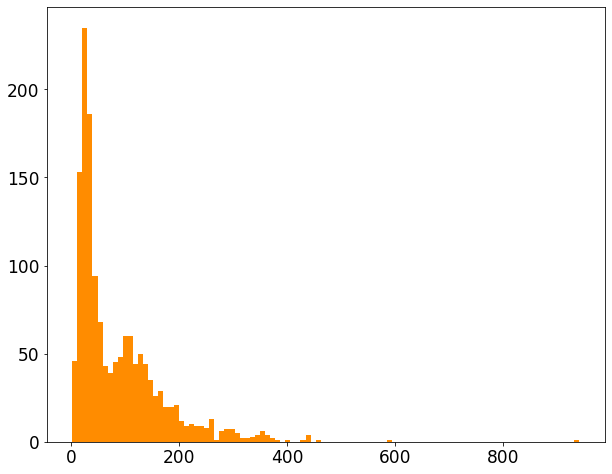

In [617]:
# Building Energy Usage Intensity
y1 = data['bld_eui2']
plt.subplots(figsize=(10,8))
plt.hist((y1), bins = 100, color = 'darkorange')
plt.show()

In [618]:
# Building Energy Usage Intensity
log_eui = np.log10(data['bld_eui2'])
log_eui_median = log_eui.median()  # Compute the Median of Building EUI

In [619]:
log_eui_median

1.7269715836828767

In [620]:
# If a building is below the median,it means it is low EUI. Otherwise, it is considered as high EUI
#data['bld_eui2_label'] = np.where(np.log10(data['bld_eui2']) < log_eui_median, "low", "high")
data['bld_eui2_label'] = np.where(np.log10(data['bld_eui2']) < 1.7269715836828767, "low", "high")

In [621]:
y = data['bld_eui2_label'].reset_index(drop=True)

In [622]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(['low','high'])
ylabel = le.transform(y)

1.749856622787119 0.4158091866375914


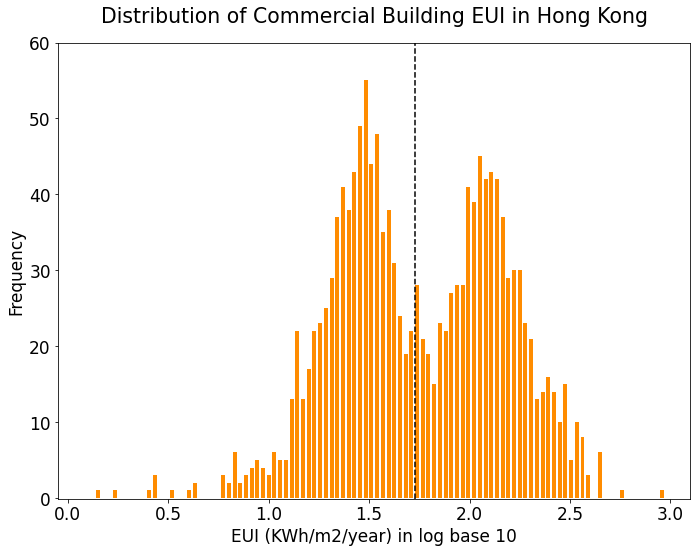

In [623]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from numpy.random import normal
from numpy import hstack
from numpy import asarray
from numpy import exp
from sklearn.neighbors import KernelDensity
from scipy.stats import norm
import pandas
import statsmodels.api as sm
from statsmodels.distributions.mixture_rvs import mixture_rvs

y1 = data['bld_eui2']
mu = np.mean(np.log10(y1))
print(np.mean(np.log10(y1)),np.std(np.log10(y1)))
sigma =np.std(np.log10(y1))
mu,sigma

fig, ax = plt.subplots(figsize=(10,8))
#ax = fig.add_subplot(111)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 17
plt.ylabel('Frequency')
plt.xlabel("EUI (KWh/m2/year) in log base 10",fontsize = 17)
plt.title("Distribution of Commercial Building EUI in Hong Kong",pad = 20)

#plt.axvline(x =1.48, color='black', linestyle='--') 
#plt.axvline(x =2.07, color='black', linestyle='--') 
plt.axvline(x = 1.7269715836828767, color='black', linestyle='--') 
plt.hist(np.log10(y1), bins = 100, color = 'darkorange', rwidth=0.7)
plt.subplots_adjust(left=0.25)
ax.set_xlim([-0.05, 3.1])  # The range of X axis
ax.set_ylim([-0.1,60])  # The range of Y axis

plt.tight_layout()
plt.show()

In [624]:
#data = data[(data.log10_eui <= log_eui_median) | (data.log10_eui > log_eui_median)]

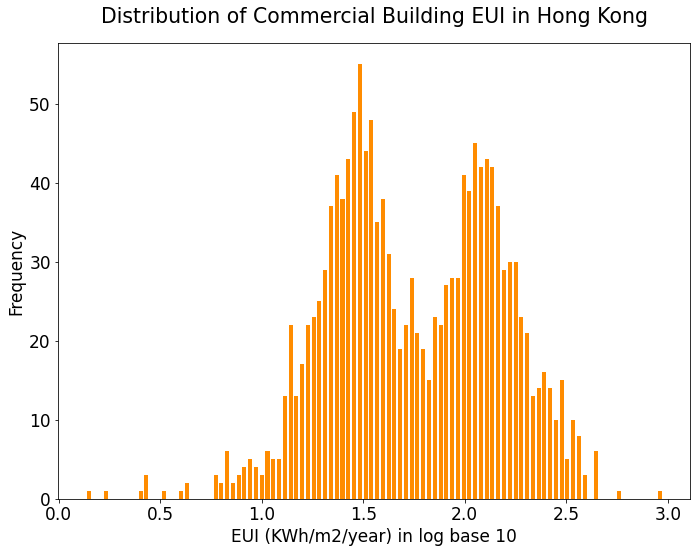

In [625]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from numpy.random import normal
from numpy import hstack
from numpy import asarray
from numpy import exp
from sklearn.neighbors import KernelDensity
from scipy.stats import norm
import pandas
import statsmodels.api as sm
from statsmodels.distributions.mixture_rvs import mixture_rvs

y1 = data['log10_eui']
fig, ax = plt.subplots(figsize=(10,8))
#ax = fig.add_subplot(111)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 17
#plt.ylabel('Frequency')
#plt.xlabel("EUI (KWh/m2/year)",fontsize = 17)
#plt.title("Distribution of Commercial Building EUI in Hong Kong (Year 2020)",pad = 20)


plt.ylabel('Frequency')
plt.xlabel("EUI (KWh/m2/year) in log base 10",fontsize = 17)
plt.title("Distribution of Commercial Building EUI in Hong Kong",pad = 20)

#plt.axvline(log_eui_median, color='black', linestyle='--') 
#plt.axvline(x =1.48, color='black', linestyle='--') 
#plt.axvline(x =2.07, color='black', linestyle='--') 
plt.hist(y1, bins = 100, color="darkorange", rwidth=0.7)
plt.subplots_adjust(left=0.25)

plt.tight_layout()
plt.show()

In [626]:
# X 

# X1+X2+X3+X4........+Xn
X = data[[
          'log_area', 
          'Storey',
          'Year_built_class',
          'log_hotel', 
          'log_parking', 
          'log_food', 
          'log_office',
          'log_retail',
          'td_cdd',
          'wind10m',
          'ghi',
          'retro_before', 
          'retro_after',
          'log_mtr_dist',
          'commercial',
          'individual_ac',
          'central_ac',
          'no_lifts_50%below', 
          'no_lifts_50%_75%', 
          'no_lifts_75%above',
          'Operate_start_before8', 
          'Operate_start_8_9',
          'Operate_start_9_10', 
          'Operate_start_after10',
          'Operate_hours_25%', 
          'Operate_hours_50%', 
          'Operate_hours_75%', 
          'Operate_hours_100%',
         'ndvi',
         'BH',
          ]].reset_index(drop=True)

In [342]:
##################################################################################################
##################################################################################################
##################################################################################################
##################################################################################################
##################################################################################################
##################################################################################################
##################################################################################################
# Import the directory of csv file
data_c = pd.read_csv(
    r"C:\Users\jhcwgtang\Downloads\city_dataset_updated_formodelling.csv",
    index_col=0, encoding='utf-8')

In [343]:

# Building Height
data_c['Area'] = np.where(data_c['highrise'] == 1, data_c['area_upper'], data_c['area_podium'])  # High
# Building Retrofitting due to Energy Audit Policy (Before and After)
data_c['retro_before'] = np.where(data_c['retro'] == 'retro_before', 1, 0)  # np.where(condition, x, y)
data_c['retro_after'] = np.where(data_c['retro'] == 'retro_after', 1, 0)  # np.where(condition, x, y)

# Year of Building Construction
data_c.loc[data_c['Year'] < 1950, 'Year_built_class'] = 1
data_c.loc[(data_c['Year'] >= 1950) & (data_c['Year'] < 1960), 'Year_built_class'] = 2
data_c.loc[(data_c['Year'] >= 1960) & (data_c['Year'] < 1970), 'Year_built_class'] = 3
data_c.loc[(data_c['Year'] >= 1970) & (data_c['Year'] < 1980), 'Year_built_class'] = 4
data_c.loc[(data_c['Year'] >= 1980) & (data_c['Year'] < 1990), 'Year_built_class'] = 5
data_c.loc[(data_c['Year'] >= 1990) & (data_c['Year'] < 2000), 'Year_built_class'] = 6
data_c.loc[(data_c['Year'] >= 2000) & (data_c['Year'] < 2010), 'Year_built_class'] = 7
data_c.loc[data_c['Year'] >= 2010, 'Year_built_class'] = 8

# Log10 transformation of Building Footprint
data_c['log_area'] = np.log10(data_c['Area'] + 1)
# Log10 transformation of Kernel Density
data_c['log_hotel'] = np.log10(data_c['hotel'] + 1)
data_c['log_retail'] = np.log10(data_c['retail'] + 1)
data_c['log_parking'] = np.log10(data_c['parking'] + 1)
data_c['log_food'] = np.log10(data_c['food'] + 1)
data_c['log_office'] = np.log10(data_c['office'] + 1)

# Distance to MTR Transit Station
data_c['log_mtr_dist'] = np.log10(data_c['Dist_mtr'])

# Only COMMERCIAL land use is considered (11)
data_c['commercial'] = np.where(data_c['landuse'] == 11, 1, 0)

########################################################################################################################
# Air condition System  # Haven't mentioned in paper (individual and central)
data_c['individual_ac'] = np.where(data_c['AC_type'] == 'Individual Air-Conditioning System', 1, 0)
data_c['central_ac'] = np.where(data_c['AC_type'] == 'Central Air-Conditioning System', 1, 0)
########################################################################################################################
# Number of Lift in a certain building
data_c['no_lifts'] = data_c['Passage_lift'] + data_c['Service_lift']  # Number of Lift = Passenger + Service
no_lifts_percentile = np.nanpercentile(data_c['no_lifts'], [50, 75])  # 50-75% Lifts
data_c['no_lifts_c'] = np.where(data_c['no_lifts'] < no_lifts_percentile[0], "no_lifts_50%below",
                              (np.where(data_c['no_lifts'] < no_lifts_percentile[1], "no_lifts_50%_75%",
                                        np.where(pd.isna(data_c['no_lifts']), np.NaN, "no_lifts_75%above"))))  # no value--> 75%

# 50% and 75% and 100%
#data['no_lifts_50%below'] = np.where(data['no_lifts_c'] == 'no_lifts_50%below', 1, 0)
#data['no_lifts_50%_75%'] = np.where(data['no_lifts_c'] == 'no_lifts_50%_75%', 1, 0)
#data['no_lifts_75%above'] = np.where(data['no_lifts_c'] == 'no_lifts_75%above', 1, 0)
########################################################################################################################
# Building Operation Time
data_c['Operate_start_before8'] = np.where(data_c['Operate_start_work'] < 8, 1, 0)
data_c['Operate_start_8_9'] = np.where(((data_c['Operate_start_work'] >= 8) & (data_c['Operate_start_work'] < 9)), 1, 0)
data_c['Operate_start_9_10'] = np.where(((data_c['Operate_start_work'] >= 9) & (data_c['Operate_start_work'] < 10)), 1, 0)
data_c['Operate_start_after10'] = np.where(data_c['Operate_start_work'] >= 10, 1, 0)

#Operate_hours_percentile = np.nanpercentile(data['Operate_hours'], [25, 50, 75])
#data['Operate_hours_c'] = np.where(data['Operate_hours'] < Operate_hours_percentile[0], 'Operate_hours_25%', # <25%
                                 #  (np.where(data['Operate_hours'] < Operate_hours_percentile[1], 'Operate_hours_50%',  # <50%
                                        #     (np.where(data['Operate_hours'] < Operate_hours_percentile[2], 'Operate_hours_75%',  # <75%
                                        #               (np.where(pd.isna(data['Operate_hours']), np.NaN, 'Operate_hours_100%')))))))  # detect missing data

#data['Operate_hours_25%'] = np.where(data['Operate_hours_c'] == 'Operate_hours_25%', 1, 0)
#data['Operate_hours_50%'] = np.where(data['Operate_hours_c'] == 'Operate_hours_50%', 1, 0)
#data['Operate_hours_75%'] = np.where(data['Operate_hours_c'] == 'Operate_hours_75%', 1, 0)
#data['Operate_hours_100%'] = np.where(data['Operate_hours_c'] == 'Operate_hours_100%', 1, 0)


In [1976]:
Dataset = data_c[[
               'log_area', 
         #'Storey',
       #  'Year_built_class',
         'log_hotel', 'log_parking', 'log_food', 'log_office', 'log_retail',
         'td_cdd',
         'wind10m',
         'ghi',
         'retro_before', 'retro_after',
         'log_mtr_dist',
         'commercial',
         'individual_ac',
         'central_ac',
       #  'no_lifts_50%below', 'no_lifts_50%_75%', 'no_lifts_75%above',
         'Operate_start_before8', 'Operate_start_8_9', 'Operate_start_9_10', 'Operate_start_after10',
        'ndvi',
        'BH',
         ]].reset_index(drop=True)
Dataset.to_csv('Citybased_dataset_v2.csv',index=False)

In [627]:
X

,log_area,Storey,Year_built_class,log_hotel,log_parking,log_food,log_office,log_retail,td_cdd,wind10m,...,Operate_start_before8,Operate_start_8_9,Operate_start_9_10,Operate_start_after10,Operate_hours_25%,Operate_hours_50%,Operate_hours_75%,Operate_hours_100%,ndvi,BH
0,2.060698,5,4.0,1.890600,1.748245,2.750192,0.000000,2.704174,2.50708,3.10741,...,0,0,0,0,0,0,0,0,0.003396,37.538166
1,2.519828,13,4.0,0.000000,2.425565,2.249458,0.000000,3.067402,2.72197,2.29804,...,0,0,0,0,0,0,0,0,0.038056,39.309444
2,2.660865,36,7.0,0.000000,1.952572,1.744457,0.000000,2.345632,2.50708,2.09989,...,0,0,0,0,0,0,0,0,0.052051,161.831970
3,2.320146,21,4.0,0.000000,1.568914,2.851846,2.516849,3.165167,2.68616,2.43564,...,0,0,0,0,0,0,0,0,0.000613,75.504829
4,2.230449,7,4.0,1.954109,0.000000,2.555555,0.000000,2.773442,2.90105,2.50368,...,0,0,0,0,0,0,0,0,0.103458,30.511705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1490,3.176381,22,5.0,2.229416,2.051565,2.960001,0.000000,2.782170,2.79360,2.37091,...,0,0,0,0,0,0,0,0,0.068834,22.569948
1491,3.526727,46,5.0,0.000000,1.042879,2.190889,2.766011,0.149559,2.50708,2.51164,...,0,0,0,0,0,0,0,0,0.021036,81.159958
1492,2.068186,15,6.0,0.000000,1.874156,3.023569,2.986979,2.550964,2.68616,2.94447,...,0,0,0,0,0,0,0,0,0.119153,51.133446
1493,2.346353,14,5.0,0.000000,1.773042,2.629082,2.808663,2.870126,2.65034,2.47397,...,0,0,0,0,0,0,0,0,0.050393,51.767632


In [629]:
y

0        low
1        low
2        low
3        low
4        low
        ... 
1490    high
1491    high
1492    high
1493    high
1494    high
Name: bld_eui2_label, Length: 1495, dtype: object

In [538]:
# X1+X2+X3+X4........+Xn
Dataset = data[[
                'bld_eui2_label',
                'full_addr_',
               'log_area',
                'Storey',
         'Year_built_class',
         'log_hotel', 'log_parking', 'log_food', 'log_office', 'log_retail',
         'td_cdd',
         'wind10m',
         'ghi',
         'retro_before', 'retro_after',
         'log_mtr_dist',
         'commercial',
         'individual_ac',
         'central_ac',
         'no_lifts_50%below', 'no_lifts_50%_75%', 'no_lifts_75%above',
         'Operate_start_before8', 'Operate_start_8_9', 'Operate_start_9_10', 'Operate_start_after10',
         'Operate_hours_25%', 'Operate_hours_50%', 'Operate_hours_75%', 'Operate_hours_100%',
        'ndbi',
        'ndvi',
        'BH'
         ]].reset_index(drop=True)
Dataset.to_csv('ALL_Dataset.csv',index=False)

In [630]:
# Random Forest
import numpy as np
seed = 8000
rf = RandomForestClassifier(random_state=seed)

n_estimators = [int(x) for x in np.linspace(start=10, stop=500, num=50)]
max_features = ['auto', 'sqrt', 'log2'] 
max_depth = [int(x) for x in np.linspace(3, 10, num=20)]
max_depth.append(None)
min_samples_split = [8, 10, 12, 14, 16, 18, 20, 30]
min_samples_leaf = [4, 6, 8]
bootstrap = [True, False]
criterion = ['gini', 'entropy']

parameter_dis = {'n_estimators': n_estimators,  # number of trees in the forest
                 'max_features': max_features,
                 'max_depth': max_depth,
                 'min_samples_split': min_samples_split,
                 'min_samples_leaf': min_samples_leaf,
                 'bootstrap': bootstrap,
                 'criterion': criterion}

rf_random = RandomizedSearchCV(estimator=rf, param_distributions=parameter_dis,
                               n_iter=200, cv=5, verbose=1, n_jobs=-1, scoring='accuracy', refit=False)
rf_random.fit(X, y)

# Selecting the best parameter
best_params_ = rf_random.best_params_

# Random Forest Classification
rf = RandomForestClassifier(random_state=seed,
                            n_estimators=best_params_['n_estimators'],
                            min_samples_split=best_params_['min_samples_split'],
                            min_samples_leaf=best_params_['min_samples_leaf'],
                            max_features=best_params_['max_features'],
                            max_depth=best_params_['max_depth'],
                            bootstrap=best_params_['bootstrap'],
                            criterion=best_params_['criterion'])

cv = KFold(n_splits=5, random_state=seed, shuffle=True)
for (train, test), i in zip(cv.split(X, y), range(5)):
    rf.fit(X.iloc[train], y.iloc[train])
    y_pred = rf.predict(X.iloc[test])
    print(metrics.classification_report(y.iloc[test], y_pred, digits=4))
    print("--------------------------------- Random Forest Result ----------------------------------------")
    print(rf.score(X.iloc[test], y.iloc[test]))

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
              precision    recall  f1-score   support

        high     0.7727    0.7338    0.7528       139
         low     0.7784    0.8125    0.7951       160

    accuracy                         0.7759       299
   macro avg     0.7756    0.7732    0.7739       299
weighted avg     0.7758    0.7759    0.7754       299

--------------------------------- Random Forest Result ----------------------------------------
0.7759197324414716
              precision    recall  f1-score   support

        high     0.8571    0.7152    0.7798       151
         low     0.7514    0.8784    0.8100       148

    accuracy                         0.7960       299
   macro avg     0.8043    0.7968    0.7949       299
weighted avg     0.8048    0.7960    0.7947       299

--------------------------------- Random Forest Result ----------------------------------------
0.7959866220735786
              precision    recall  f1-score   suppor

In [536]:
prediction = pd.DataFrame(y_pred, columns=['predictions']).to_csv('prediction.csv')
test = pd.DataFrame(test, columns=['test']).to_csv('test.csv')


In [346]:
########################################################################################################################
df_fill = pd.read_csv('Citybased_dataset_v2.csv')
df_fill.head()

,log_area,log_hotel,log_parking,log_food,log_office,log_retail,td_cdd,wind10m,ghi,retro_before,...,commercial,individual_ac,central_ac,Operate_start_before8,Operate_start_8_9,Operate_start_9_10,Operate_start_after10,ndbi,ndvi,BH
0,3.246006,0.000000,2.216533,3.189482,2.556313,3.840857,2.148925,2.463391,1410.595947,0,...,1,0,1,0,1,0,0,0.018381,0.065830,76.463356
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.256371,2.519921,1473.784058,0,...,0,1,0,0,0,0,0,-0.050936,0.481891,7.344049
2,2.758155,1.336582,1.976251,2.298341,1.904677,2.616486,2.542894,4.066162,1434.337036,0,...,0,1,0,0,0,0,0,0.066298,0.049907,71.445358
3,2.758155,1.336582,1.976251,2.298341,1.904677,2.616486,2.542894,4.066162,1434.337036,0,...,0,0,1,0,1,0,0,0.066298,0.049907,71.445358
4,2.176091,0.000000,1.892810,2.796796,0.000000,2.192669,2.507079,3.288898,1434.337036,0,...,0,0,0,0,0,0,0,-0.002453,0.034890,88.218895


In [539]:
ya = rf.predict(df_fill)
print(pd.DataFrame(ya,columns=['eui']))

results = pd.DataFrame(ya)
data_filled = df_fill.join(results)
data_filled.to_csv('RF_prediction.csv')
########################################################################################################################

The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- ndbi
Feature names seen at fit time, yet now missing:
- Operate_hours_100%
- Operate_hours_25%
- Operate_hours_50%
- Operate_hours_75%
- Storey
- ...



ValueError: X has 22 features, but RandomForestClassifier is expecting 30 features as input.

In [631]:
# XGBoost
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import xgboost as xgb

data_matrix = xgb.DMatrix(data=X, label=ylabel)

# set the prarameter 
space = {'max_depth': hp.quniform("max_depth", 3, 10, 1),
         'learning_rate': hp.uniform("learning_rate", 0.05, 0.3),
         'colsample_bytree': hp.uniform("colsample_bytree", 0.5, 1),
         'min_child_weight': hp.quniform("min_child_weight", 1, 20, 1),
         'reg_alpha': hp.quniform("reg_alpha", 0, 100, 1),
         'reg_lambda': hp.uniform("reg_lambda", 0, 2),
         'subsample': hp.uniform("subsample", 0.5, 1),
         'min_split_loss': hp.uniform("min_split_loss", 0, 9),
         'rate_drop': hp.uniform("rate_drop", 0, 1)}


def fobjective(space):
    param_dict_tunning = {'max_depth': int(space['max_depth']),
                          'learning_rate': space['learning_rate'],
                          'colsample_bytree': space['colsample_bytree'],
                          'min_child_weight': int(space['min_child_weight']),
                          'reg_alpha': int(space['reg_alpha']),
                          'reg_lambda': space['reg_lambda'],
                          'subsample': space['subsample'],
                          'min_split_loss': space['min_split_loss'],
                          'booster': 'gbtree',
                          # 'rate_drop': space['rate_drop'],
                          'objective': 'binary:logistic'}
    xgb_cv_result = xgb.cv(dtrain=data_matrix, params=param_dict_tunning, nfold=5, early_stopping_rounds=30,
                           as_pandas=True, num_boost_round=200, seed=8000, metrics='error')

    return {"loss": (xgb_cv_result["test-error-mean"]).tail(1).iloc[0], "status": STATUS_OK}


trials = Trials()
best_hyperparams = fmin(fn=fobjective, space=space, algo=tpe.suggest, max_evals=200, trials=trials)

param_dict_tunning = {'objective': 'binary:logistic', 'eval_metric': 'error',
                      'max_depth': int(best_hyperparams['max_depth']),
                      'reg_alpha': best_hyperparams['reg_alpha'], 'reg_lambda': best_hyperparams['reg_lambda'],
                      'min_child_weight': best_hyperparams['min_child_weight'],
                      'colsample_bytree': best_hyperparams['colsample_bytree'],
                      'learning_rate': best_hyperparams['learning_rate'], 'subsample': best_hyperparams['subsample'],
                      'min_split_loss': best_hyperparams['min_split_loss'],
                      # 'rate_drop':best_hyperparams['rate_drop'],
                      'booster': 'gbtree'}

for train, test in KFold(n_splits=5, shuffle=True, random_state=8000).split(X, ylabel):
    input_matrix = xgb.DMatrix(data=X.loc[train], label=ylabel[train])
    test_matrix = xgb.DMatrix(data=X.loc[test], label=ylabel[test])
    watchlist = [(test_matrix, 'eval'), (input_matrix, 'train')]

    xgb_model = xgb.train(params=param_dict_tunning, dtrain=input_matrix, num_boost_round=200, evals=watchlist,
                          xgb_model=None, verbose_eval=False, early_stopping_rounds=30)

    y_pred_pro = xgb_model.predict(test_matrix)
    y_pred = [round(value) for value in y_pred_pro]
    y_true = ylabel[test]
    print("----------------------------------------- XGBoost Result -------------------------------------------------")
    print(metrics.classification_report(y_true, y_pred, digits=4))

  0%|▏                                              | 1/200 [00:00<00:30,  6.46trial/s, best loss: 0.49966540000000004]

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


100%|███████████████████████████████████████████████████████| 200/200 [01:08<00:00,  2.91trial/s, best loss: 0.2167226]
----------------------------------------- XGBoost Result -------------------------------------------------


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


              precision    recall  f1-score   support

           0     0.7836    0.7554    0.7692       139
           1     0.7939    0.8187    0.8062       160

    accuracy                         0.7893       299
   macro avg     0.7888    0.7871    0.7877       299
weighted avg     0.7891    0.7893    0.7890       299

----------------------------------------- XGBoost Result -------------------------------------------------
              precision    recall  f1-score   support

           0     0.8346    0.7020    0.7626       151
           1     0.7384    0.8581    0.7938       148

    accuracy                         0.7793       299
   macro avg     0.7865    0.7800    0.7782       299
weighted avg     0.7870    0.7793    0.7780       299

----------------------------------------- XGBoost Result -------------------------------------------------
              precision    recall  f1-score   support

           0     0.7972    0.7308    0.7625       156
           1     0.7308

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


----------------------------------------- XGBoost Result -------------------------------------------------
              precision    recall  f1-score   support

           0     0.8182    0.6735    0.7388       147
           1     0.7303    0.8553    0.7879       152

    accuracy                         0.7659       299
   macro avg     0.7743    0.7644    0.7633       299
weighted avg     0.7735    0.7659    0.7638       299

----------------------------------------- XGBoost Result -------------------------------------------------
              precision    recall  f1-score   support

           0     0.8308    0.6968    0.7579       155
           1     0.7219    0.8472    0.7796       144

    accuracy                         0.7692       299
   macro avg     0.7763    0.7720    0.7687       299
weighted avg     0.7783    0.7692    0.7683       299



pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [601]:
prediction_xgb = pd.DataFrame(y_pred, columns=['predictions']).to_csv('prediction_xgb.csv')
test_xgb = pd.DataFrame(test, columns=['test']).to_csv('test_xgb.csv')
lable_xgb = pd.DataFrame(ylabel[test], columns=['lable']).to_csv('lable_xgb.csv')

In [1902]:
########################################################################################################################
df_fill_2 = pd.read_csv('Citybased_dataset.csv')
df_fill_2.head()

,log_area,Storey,Year_built_class,log_hotel,log_parking,log_food,log_office,log_retail,td_cdd,wind10m,...,commercial,individual_ac,central_ac,Operate_start_before8,Operate_start_8_9,Operate_start_9_10,Operate_start_after10,ndbi,ndvi,BH
0,2.060698,5,4.0,1.890600,1.748245,2.750192,0.000000,2.704174,2.50708,3.10741,...,0,0,0,0,0,0,0,0.145720,0.003396,37.538166
1,2.519828,13,4.0,0.000000,2.425565,2.249458,0.000000,3.067402,2.72197,2.29804,...,0,0,0,0,0,0,0,0.052908,0.038056,39.309444
2,2.660865,36,7.0,0.000000,1.952572,1.744457,0.000000,2.345632,2.50708,2.09989,...,0,0,0,0,0,0,0,-0.007362,0.052051,161.831970
3,2.320146,21,4.0,0.000000,1.568914,2.851846,2.516849,3.165167,2.68616,2.43564,...,0,0,0,0,0,0,0,0.066142,0.000613,75.504829
4,2.230449,7,4.0,1.954109,0.000000,2.555555,0.000000,2.773442,2.90105,2.50368,...,0,0,0,0,0,0,0,0.063666,0.103458,30.511705


In [1912]:
data_fill_2 = xgb.DMatrix(data=df_fill_2)
ya_2 = xgb_model.predict(data_fill_2)
print(pd.DataFrame(ya_2,columns=['eui']))

results_2 = pd.DataFrame(ya_2)
data_filled2 = df_fill.join(results_2)

data_filled2.to_csv('XGBoost_prediction.csv')

           eui
0     0.918049
1     0.954193
2     0.726220
3     0.910774
4     0.942298
...        ...
1490  0.476043
1491  0.019898
1492  0.260667
1493  0.915005
1494  0.197609

[1495 rows x 1 columns]


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


PermissionError: [Errno 13] Permission denied: 'XGBoost_prediction.csv'

In [637]:
# Deep learning
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler

seed = 8000

input_scaler = MinMaxScaler()
input_scaler.fit(X)
X_normalized = input_scaler.transform(X)

model = Sequential()
model.add(Dense(24, input_dim=len(X.iloc[0]), activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

cv = KFold(n_splits=5, random_state=seed, shuffle=True)
for (train, test), i in zip(cv.split(X_normalized, ylabel), range(5)):
    model.fit(X_normalized[train], ylabel[train], epochs=150, batch_size=1024, verbose=0)

    y_pred_pro = model.predict(X_normalized[test], batch_size=1024, verbose=0)
    y_pred = np.round(y_pred_pro)
    print("----------------------------------- Deep Learning Result -------------------------------------------------")
    print(metrics.classification_report(ylabel[test], y_pred, digits=4))

     #accuracy = model.evaluate(X_normalized[test], ylabel[test],batch_size=1024,verbose=0)
     #print('Accuracy: %.2f' % (accuracy*100))

----------------------------------- Deep Learning Result -------------------------------------------------
              precision    recall  f1-score   support

           0     0.7541    0.6619    0.7050       139
           1     0.7345    0.8125    0.7715       160

    accuracy                         0.7425       299
   macro avg     0.7443    0.7372    0.7382       299
weighted avg     0.7436    0.7425    0.7406       299

----------------------------------- Deep Learning Result -------------------------------------------------
              precision    recall  f1-score   support

           0     0.8468    0.6954    0.7636       151
           1     0.7371    0.8716    0.7988       148

    accuracy                         0.7826       299
   macro avg     0.7920    0.7835    0.7812       299
weighted avg     0.7925    0.7826    0.7810       299

----------------------------------- Deep Learning Result -------------------------------------------------
              precision  

In [596]:
prediction_dp = pd.DataFrame(y_pred, columns=['predictions']).to_csv('prediction_dp.csv')
test_dp = pd.DataFrame(test).to_csv('test_dp.csv')
lable_dp = pd.DataFrame(ylabel[test], columns=['lable']).to_csv('lable_dp.csv')

In [1898]:
########################################################################################################################
df_fill_3 = pd.read_csv('Citybased_dataset.csv')
df_fill_3.head()

,log_area,Storey,Year_built_class,log_hotel,log_parking,log_food,log_office,log_retail,td_cdd,wind10m,...,commercial,individual_ac,central_ac,Operate_start_before8,Operate_start_8_9,Operate_start_9_10,Operate_start_after10,ndbi,ndvi,BH
0,2.060698,5,4.0,1.890600,1.748245,2.750192,0.000000,2.704174,2.50708,3.10741,...,0,0,0,0,0,0,0,0.145720,0.003396,37.538166
1,2.519828,13,4.0,0.000000,2.425565,2.249458,0.000000,3.067402,2.72197,2.29804,...,0,0,0,0,0,0,0,0.052908,0.038056,39.309444
2,2.660865,36,7.0,0.000000,1.952572,1.744457,0.000000,2.345632,2.50708,2.09989,...,0,0,0,0,0,0,0,-0.007362,0.052051,161.831970
3,2.320146,21,4.0,0.000000,1.568914,2.851846,2.516849,3.165167,2.68616,2.43564,...,0,0,0,0,0,0,0,0.066142,0.000613,75.504829
4,2.230449,7,4.0,1.954109,0.000000,2.555555,0.000000,2.773442,2.90105,2.50368,...,0,0,0,0,0,0,0,0.063666,0.103458,30.511705


In [1913]:
X_normalized_dp = input_scaler.transform(df_fill_3)

ya_3 = model.predict(df_fill_3, batch_size=1024, verbose=0)
print(pd.DataFrame(ya_3,columns=['eui']))

results_3 = pd.DataFrame(ya_3)
data_filled_3 = df_fill.join(results_3)
data_filled_3.to_csv('DeepLearning_prediction.csv')
########################################################################################################################

               eui
0     1.000000e+00
1     1.000000e+00
2     3.059054e-10
3     1.000000e+00
4     1.000000e+00
...            ...
1490  1.000000e+00
1491  1.000000e+00
1492  1.000000e+00
1493  1.000000e+00
1494  1.000000e+00

[1495 rows x 1 columns]


In [633]:
# Support vector machine

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler

seed = 8000

input_scaler = MinMaxScaler()
input_scaler.fit(X)
X_normalized = input_scaler.transform(X)

param_SVC = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf', 'poly', 'sigmoid']}

SVC_grid = GridSearchCV(SVC(), param_SVC, refit=False, verbose=0, cv=5, scoring='accuracy')
SVC_grid.fit(X_normalized, ylabel)

SVC_model = SVC(**SVC_grid.best_params_)

cv = KFold(n_splits=5, random_state=seed, shuffle=True)
for (train, test), i in zip(cv.split(X_normalized, ylabel), range(5)):
    SVC_model.fit(X_normalized[train], y[train])

    y_pred = SVC_model.predict(X_normalized[test])
    print("--------------------------------------------- SVM Result -------------------------------------------------")
    print(metrics.classification_report(y[test], y_pred, digits=4))

    print(SVC_model.score(X_normalized[test], y[test]))

--------------------------------------------- SVM Result -------------------------------------------------
              precision    recall  f1-score   support

        high     0.8039    0.5899    0.6805       139
         low     0.7107    0.8750    0.7843       160

    accuracy                         0.7425       299
   macro avg     0.7573    0.7325    0.7324       299
weighted avg     0.7540    0.7425    0.7361       299

0.7424749163879598
--------------------------------------------- SVM Result -------------------------------------------------
              precision    recall  f1-score   support

        high     0.8716    0.6291    0.7308       151
         low     0.7053    0.9054    0.7929       148

    accuracy                         0.7659       299
   macro avg     0.7884    0.7673    0.7618       299
weighted avg     0.7892    0.7659    0.7615       299

0.7658862876254181
--------------------------------------------- SVM Result -------------------------------------

In [1873]:
########################################################################################################################
df_fill_4 = pd.read_csv('Citybased_dataset.csv')
df_fill_4.head()

,log_area,Storey,Year_built_class,log_hotel,log_parking,log_food,log_office,log_retail,td_cdd,wind10m,...,commercial,individual_ac,central_ac,Operate_start_before8,Operate_start_8_9,Operate_start_9_10,Operate_start_after10,ndbi,ndvi,BH
0,2.060698,5,4.0,1.890600,1.748245,2.750192,0.000000,2.704174,2.50708,3.10741,...,0,0,0,0,0,0,0,0.145720,0.003396,37.538166
1,2.519828,13,4.0,0.000000,2.425565,2.249458,0.000000,3.067402,2.72197,2.29804,...,0,0,0,0,0,0,0,0.052908,0.038056,39.309444
2,2.660865,36,7.0,0.000000,1.952572,1.744457,0.000000,2.345632,2.50708,2.09989,...,0,0,0,0,0,0,0,-0.007362,0.052051,161.831970
3,2.320146,21,4.0,0.000000,1.568914,2.851846,2.516849,3.165167,2.68616,2.43564,...,0,0,0,0,0,0,0,0.066142,0.000613,75.504829
4,2.230449,7,4.0,1.954109,0.000000,2.555555,0.000000,2.773442,2.90105,2.50368,...,0,0,0,0,0,0,0,0.063666,0.103458,30.511705


In [1890]:
ya_4 = SVC_model.predict(df_fill_4)
print(pd.DataFrame(ya_4,columns=['eui']))

results_4 = pd.DataFrame(ya_4)
data_filled4 = df_fill.join(results_4)
data_filled4.to_csv('SVC_prediction.csv')
########################################################################################################################

       eui
0     high
1     high
2     high
3     high
4     high
...    ...
1490  high
1491  high
1492  high
1493  high
1494  high

[1495 rows x 1 columns]


X has feature names, but SVC was fitted without feature names


In [634]:
########################################################################################################################
# Naive Bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification

params_NB = {'var_smoothing': np.logspace(0, -9, num=100)}

NB_grid = GridSearchCV(GaussianNB(), param_grid=params_NB, cv=5, verbose=0, scoring='accuracy')
NB_grid.fit(X, ylabel)

NB_model = GaussianNB(**NB_grid.best_params_)

cv = KFold(n_splits=5, random_state=seed, shuffle=True)
for (train, test), i in zip(cv.split(X, ylabel), range(5)):
    NB_model.fit(X.iloc[train], y[train])
    y_pred = NB_model.predict(X.iloc[test])
    print("------------------------------------- Native Bayes Result -------------------------------------------------")
    print(metrics.classification_report(y.iloc[test], y_pred, digits=4))
    print(NB_model.score(X.iloc[test], y[test]))

------------------------------------- Native Bayes Result -------------------------------------------------
              precision    recall  f1-score   support

        high     0.7959    0.5612    0.6582       139
         low     0.6965    0.8750    0.7756       160

    accuracy                         0.7291       299
   macro avg     0.7462    0.7181    0.7169       299
weighted avg     0.7427    0.7291    0.7210       299

0.7290969899665551
------------------------------------- Native Bayes Result -------------------------------------------------
              precision    recall  f1-score   support

        high     0.8990    0.5894    0.7120       151
         low     0.6900    0.9324    0.7931       148

    accuracy                         0.7592       299
   macro avg     0.7945    0.7609    0.7526       299
weighted avg     0.7955    0.7592    0.7521       299

0.7591973244147158
------------------------------------- Native Bayes Result ----------------------------------

In [1888]:
########################################################################################################################
df_fill_5 = pd.read_csv('Citybased_dataset.csv')
df_fill_5.head()

,log_area,Storey,Year_built_class,log_hotel,log_parking,log_food,log_office,log_retail,td_cdd,wind10m,...,commercial,individual_ac,central_ac,Operate_start_before8,Operate_start_8_9,Operate_start_9_10,Operate_start_after10,ndbi,ndvi,BH
0,2.060698,5,4.0,1.890600,1.748245,2.750192,0.000000,2.704174,2.50708,3.10741,...,0,0,0,0,0,0,0,0.145720,0.003396,37.538166
1,2.519828,13,4.0,0.000000,2.425565,2.249458,0.000000,3.067402,2.72197,2.29804,...,0,0,0,0,0,0,0,0.052908,0.038056,39.309444
2,2.660865,36,7.0,0.000000,1.952572,1.744457,0.000000,2.345632,2.50708,2.09989,...,0,0,0,0,0,0,0,-0.007362,0.052051,161.831970
3,2.320146,21,4.0,0.000000,1.568914,2.851846,2.516849,3.165167,2.68616,2.43564,...,0,0,0,0,0,0,0,0.066142,0.000613,75.504829
4,2.230449,7,4.0,1.954109,0.000000,2.555555,0.000000,2.773442,2.90105,2.50368,...,0,0,0,0,0,0,0,0.063666,0.103458,30.511705


In [1889]:
ya_5 = NB_model.predict(df_fill_5)
print(pd.DataFrame(ya_5,columns=['eui']))

results_5 = pd.DataFrame(ya_5)
data_filled5 = df_fill.join(results_5)
data_filled5.to_csv('NB_prediction.csv')
########################################################################################################################

       eui
0      low
1      low
2     high
3      low
4      low
...    ...
1490   low
1491  high
1492   low
1493   low
1494   low

[1495 rows x 1 columns]


In [1892]:
df_fill_6 = pd.read_csv('Citybased_dataset.csv')
df_fill_6.head()

,log_area,Storey,Year_built_class,log_hotel,log_parking,log_food,log_office,log_retail,td_cdd,wind10m,...,commercial,individual_ac,central_ac,Operate_start_before8,Operate_start_8_9,Operate_start_9_10,Operate_start_after10,ndbi,ndvi,BH
0,2.060698,5,4.0,1.890600,1.748245,2.750192,0.000000,2.704174,2.50708,3.10741,...,0,0,0,0,0,0,0,0.145720,0.003396,37.538166
1,2.519828,13,4.0,0.000000,2.425565,2.249458,0.000000,3.067402,2.72197,2.29804,...,0,0,0,0,0,0,0,0.052908,0.038056,39.309444
2,2.660865,36,7.0,0.000000,1.952572,1.744457,0.000000,2.345632,2.50708,2.09989,...,0,0,0,0,0,0,0,-0.007362,0.052051,161.831970
3,2.320146,21,4.0,0.000000,1.568914,2.851846,2.516849,3.165167,2.68616,2.43564,...,0,0,0,0,0,0,0,0.066142,0.000613,75.504829
4,2.230449,7,4.0,1.954109,0.000000,2.555555,0.000000,2.773442,2.90105,2.50368,...,0,0,0,0,0,0,0,0.063666,0.103458,30.511705


The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- log_food
- log_hotel
- log_office
- log_parking
- log_retail
Feature names seen at fit time, yet now missing:
- Operate_hours_100%
- Operate_hours_25%
- Operate_hours_50%
- Operate_hours_75%
- food
- ...



ValueError: X has 24 features, but LogisticRegression is expecting 31 features as input.

In [635]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(max_iter=500)

cv = KFold(n_splits=5, random_state=seed, shuffle=True)

for (train, test), i in zip(cv.split(X, ylabel), range(5)):
    logit.fit(X.iloc[train], ylabel[train])
    y_pred = logit.predict(X.iloc[test])
    print("--------------------------------- Logistic Regression Result ----------------------------------------")
    print(metrics.classification_report(ylabel[test], y_pred, digits=4))
    print("--------------------------------- Logistic Regression Result ----------------------------------------")
    print(logit.score(X.iloc[test], ylabel[test]))

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


--------------------------------- Logistic Regression Result ----------------------------------------
              precision    recall  f1-score   support

           0     0.7600    0.6835    0.7197       139
           1     0.7471    0.8125    0.7784       160

    accuracy                         0.7525       299
   macro avg     0.7536    0.7480    0.7491       299
weighted avg     0.7531    0.7525    0.7511       299

--------------------------------- Logistic Regression Result ----------------------------------------
0.7525083612040134
--------------------------------- Logistic Regression Result ----------------------------------------
              precision    recall  f1-score   support

           0     0.8455    0.6887    0.7591       151
           1     0.7330    0.8716    0.7963       148

    accuracy                         0.7793       299
   macro avg     0.7892    0.7802    0.7777       299
weighted avg     0.7898    0.7793    0.7775       299

---------------------

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


--------------------------------- Logistic Regression Result ----------------------------------------
              precision    recall  f1-score   support

           0     0.8248    0.7244    0.7713       156
           1     0.7346    0.8322    0.7803       143

    accuracy                         0.7759       299
   macro avg     0.7797    0.7783    0.7758       299
weighted avg     0.7817    0.7759    0.7756       299

--------------------------------- Logistic Regression Result ----------------------------------------
0.7759197324414716
--------------------------------- Logistic Regression Result ----------------------------------------
              precision    recall  f1-score   support

           0     0.8211    0.6871    0.7481       147
           1     0.7386    0.8553    0.7927       152

    accuracy                         0.7726       299
   macro avg     0.7799    0.7712    0.7704       299
weighted avg     0.7792    0.7726    0.7708       299

---------------------

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [1895]:
df_fill_6 = pd.read_csv('Citybased_dataset.csv')
df_fill_6.head()

,log_area,Storey,Year_built_class,log_hotel,log_parking,log_food,log_office,log_retail,td_cdd,wind10m,...,commercial,individual_ac,central_ac,Operate_start_before8,Operate_start_8_9,Operate_start_9_10,Operate_start_after10,ndbi,ndvi,BH
0,2.060698,5,4.0,1.890600,1.748245,2.750192,0.000000,2.704174,2.50708,3.10741,...,0,0,0,0,0,0,0,0.145720,0.003396,37.538166
1,2.519828,13,4.0,0.000000,2.425565,2.249458,0.000000,3.067402,2.72197,2.29804,...,0,0,0,0,0,0,0,0.052908,0.038056,39.309444
2,2.660865,36,7.0,0.000000,1.952572,1.744457,0.000000,2.345632,2.50708,2.09989,...,0,0,0,0,0,0,0,-0.007362,0.052051,161.831970
3,2.320146,21,4.0,0.000000,1.568914,2.851846,2.516849,3.165167,2.68616,2.43564,...,0,0,0,0,0,0,0,0.066142,0.000613,75.504829
4,2.230449,7,4.0,1.954109,0.000000,2.555555,0.000000,2.773442,2.90105,2.50368,...,0,0,0,0,0,0,0,0.063666,0.103458,30.511705


In [1896]:
ya_6 = logit.predict(df_fill_6)
print(pd.DataFrame(ya_6,columns=['eui']))

results_6 = pd.DataFrame(ya_6)
data_filled_6 = df_fill.join(results_6)
data_filled_6.to_csv('Logit_prediction.csv')

      eui
0       1
1       1
2       0
3       1
4       1
...   ...
1490    0
1491    0
1492    1
1493    1
1494    1

[1495 rows x 1 columns]


100%|===================| 2978/2990 [02:12<00:00]        

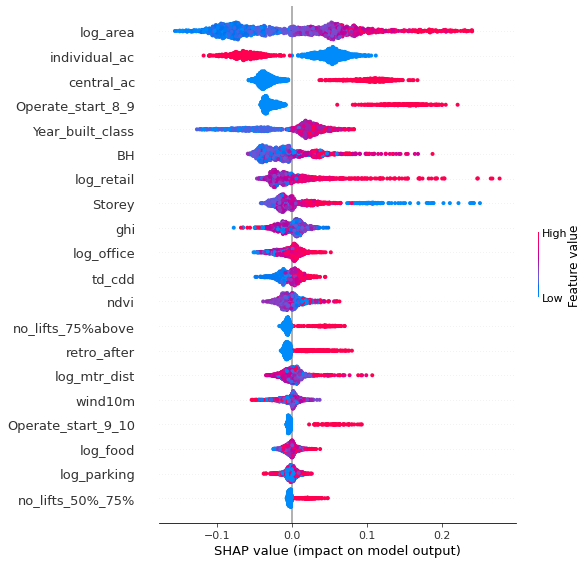

In [638]:
# Shapley Value
import shap
import sklearn
from sklearn.ensemble import RandomForestRegressor

explainer = shap.TreeExplainer(rf, X, model_output='probability')
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values[0], X)

plt.show()

In [63]:
X = data[[
          'log_area', 
          'Storey',
          'Year_built_class',
          'log_hotel', 
          'log_parking', 
          'log_food', 
          'log_office',
          'log_retail',
          'td_cdd',
          'wind10m',
          'ghi',
          'retro_before', 
          'retro_after',
          'log_mtr_dist',
          'commercial',
          'individual_ac',
          'central_ac',
          'no_lifts_50%below', 
          'no_lifts_50%_75%', 
          'no_lifts_75%above',
          'Operate_start_before8', 
          'Operate_start_8_9',
          'Operate_start_9_10', 
          'Operate_start_after10',
     #     'Operate_hours_25%', 
     #     'Operate_hours_50%', 
     #     'Operate_hours_75%', 
     #     'Operate_hours_100%',
     #    'ndbi',
         'ndvi',
         'BH',
     #    'BV'
          ]].reset_index(drop=True)

ValueError: The beeswarm plot does not support plotting explanations with instances that have more than one dimension!

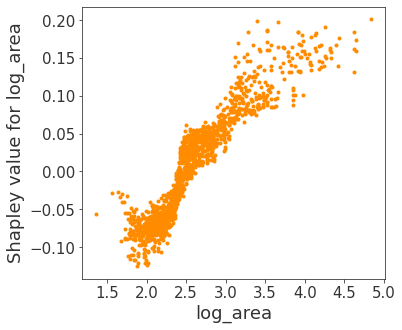

In [88]:
shap.dependence_plot("log_area", shap_values[0], X, interaction_index=None, show=False, color="darkorange", ax=None)

plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)
plt.xlabel('log_area',fontsize=18)
plt.ylabel('Shapley value for log_area',fontsize=18)
plt.show()

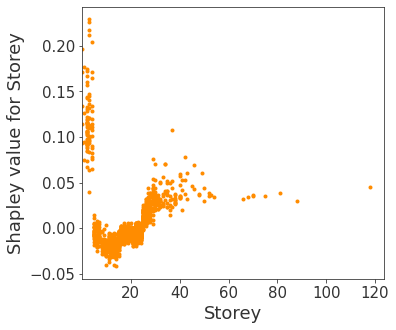

In [93]:
shap.dependence_plot("Storey", shap_values[0], X, xmin=0.01, interaction_index=None, show=False, color="darkorange", ax=None)

plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)
plt.xlabel('Storey',fontsize=18)
plt.ylabel('Shapley value for Storey',fontsize=18)
plt.show()

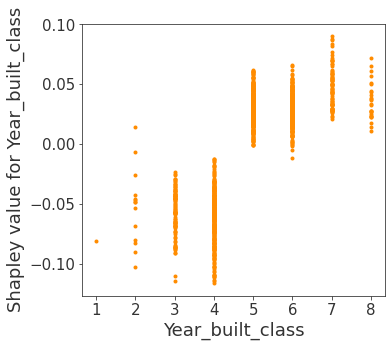

In [96]:
shap.dependence_plot("Year_built_class", shap_values[0], X, interaction_index=None, show=False, ax=None, color="darkorange")
plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)
plt.xlabel('Year_built_class',fontsize=18)
plt.ylabel('Shapley value for Year_built_class',fontsize=18)
plt.show()

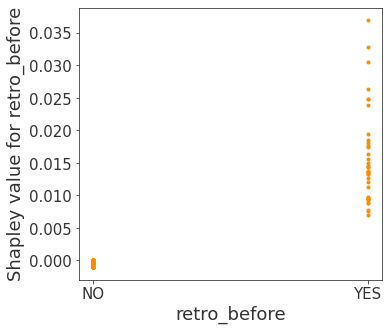

In [99]:
shap.dependence_plot("retro_before", shap_values[0], X, interaction_index=None, show=False, ax=None, color="darkorange")
plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)

plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)
x = [0,1]
label = ['NO','YES']
plt.xticks(x,label,fontsize=15)

plt.xlabel('retro_before',fontsize=18)
plt.ylabel('Shapley value for retro_before',fontsize=18)
plt.show()

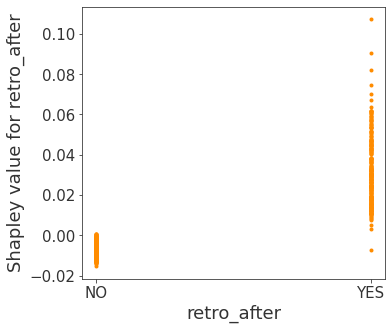

In [100]:
shap.dependence_plot("retro_after", shap_values[0], X, interaction_index=None, show=False, ax=None, color="darkorange")
plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)

plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)
x = [0,1]
label = ['NO','YES']
plt.xticks(x,label,fontsize=15)

plt.xlabel('retro_after',fontsize=18)
plt.ylabel('Shapley value for retro_after',fontsize=18)
plt.show()

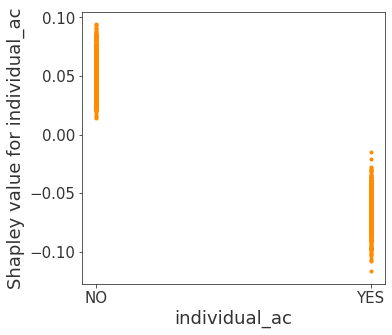

In [103]:
shap.dependence_plot("individual_ac", shap_values[0], X, interaction_index=None, show=False, ax=None, color="darkorange")
plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)
x = [0,1]
label = ['NO','YES']
plt.xticks(x,label,fontsize=15)
plt.xlabel('individual_ac',fontsize=18)
plt.ylabel('Shapley value for individual_ac',fontsize=18)
plt.show()

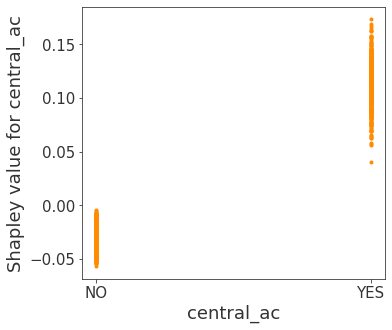

In [107]:
shap.dependence_plot("central_ac", shap_values[0], X, interaction_index=None, show=False, ax=None, color="darkorange")
plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)
x = [0,1]
label = ['NO','YES']
plt.xticks(x,label,fontsize=15)
plt.xlabel('central_ac',fontsize=18)
plt.ylabel('Shapley value for central_ac',fontsize=18)
plt.show()

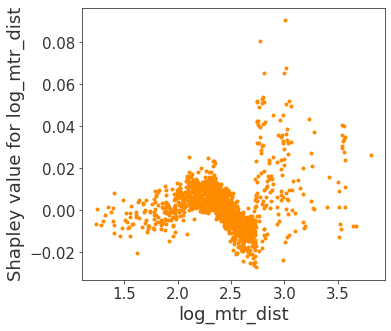

In [110]:
shap.dependence_plot("log_mtr_dist", shap_values[0], X, interaction_index=None, show=False, ax=None, color="darkorange")
plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)

plt.xlabel('log_mtr_dist',fontsize=18)
plt.ylabel('Shapley value for log_mtr_dist',fontsize=18)
plt.show()

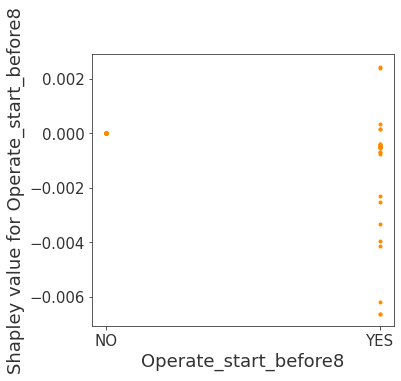

In [112]:
shap.dependence_plot("Operate_start_before8", shap_values[0], X, interaction_index=None, show=False, ax=None, color="darkorange")
plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)
x = [0,1]
label = ['NO','YES']
plt.xticks(x,label,fontsize=15)
plt.xlabel('Operate_start_before8',fontsize=18)
plt.ylabel('Shapley value for Operate_start_before8',fontsize=18)
plt.show()

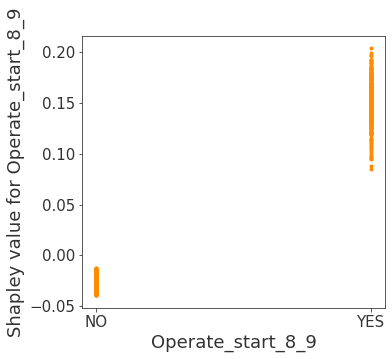

In [113]:
shap.dependence_plot("Operate_start_8_9", shap_values[0], X, interaction_index=None, show=False, ax=None, color="darkorange")
plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)
x = [0,1]
label = ['NO','YES']
plt.xticks(x,label,fontsize=15)
plt.xlabel('Operate_start_8_9',fontsize=18)
plt.ylabel('Shapley value for Operate_start_8_9',fontsize=18)
plt.show()

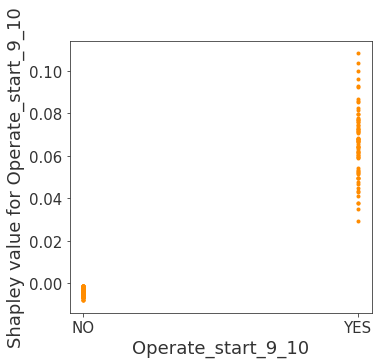

In [114]:
shap.dependence_plot("Operate_start_9_10", shap_values[0], X, interaction_index=None, show=False, ax=None, color="darkorange")
plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)
x = [0,1]
label = ['NO','YES']
plt.xticks(x,label,fontsize=15)
plt.xlabel('Operate_start_9_10',fontsize=18)
plt.ylabel('Shapley value for Operate_start_9_10',fontsize=18)
plt.show()

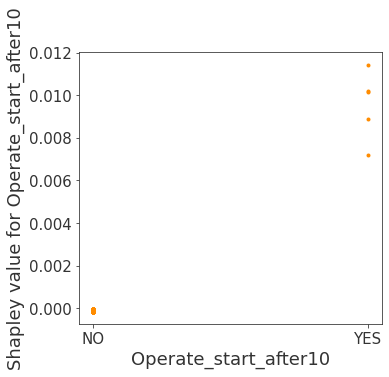

In [115]:
shap.dependence_plot("Operate_start_after10", shap_values[0], X, interaction_index=None, show=False, ax=None, color="darkorange")
plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)
x = [0,1]
label = ['NO','YES']
plt.xticks(x,label,fontsize=15)
plt.xlabel('Operate_start_after10',fontsize=18)
plt.ylabel('Shapley value for Operate_start_after10',fontsize=18)
plt.show()

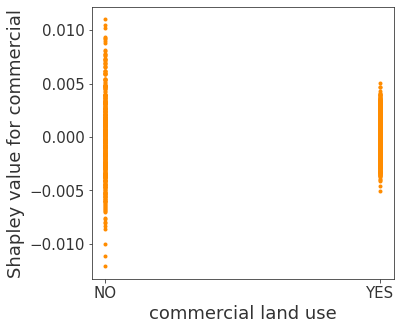

In [117]:
shap.dependence_plot("commercial", shap_values[0], X, interaction_index=None, show=False, ax=None, color="darkorange")
plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)
x = [0,1]
label = ['NO','YES']
plt.xticks(x,label,fontsize=15)
plt.xlabel('commercial land use',fontsize=18)
plt.ylabel('Shapley value for commercial',fontsize=18)
plt.show()

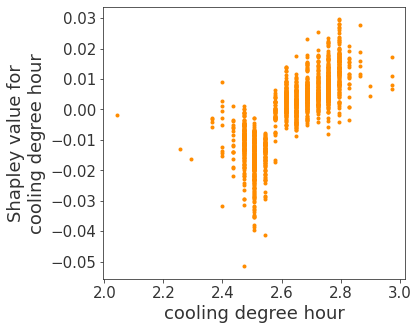

In [120]:
shap.dependence_plot("td_cdd", shap_values[0], X, interaction_index=None, show=False, ax=None, color="darkorange")
plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)

plt.xlabel('cooling degree hour',fontsize=18)
plt.ylabel('Shapley value for\ncooling degree hour',fontsize=18)
plt.show()

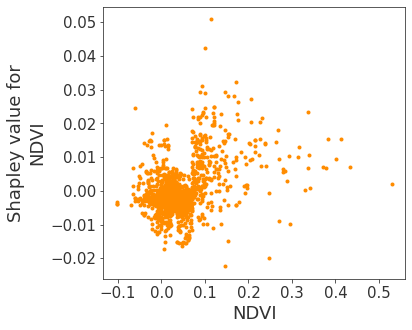

In [350]:
shap.dependence_plot("ndvi", shap_values[0], X, interaction_index=None, show=False, ax=None, color="darkorange")
plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)

plt.xlabel('NDVI',fontsize=18)
plt.ylabel('Shapley value for\nNDVI',fontsize=18)
plt.show()

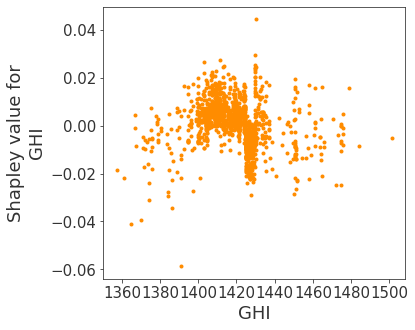

In [353]:
shap.dependence_plot("ghi", shap_values[0], X, interaction_index=None, show=False, ax=None, color="darkorange")
plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)

plt.xlabel('GHI',fontsize=18)
plt.ylabel('Shapley value for\nGHI',fontsize=18)
plt.show()

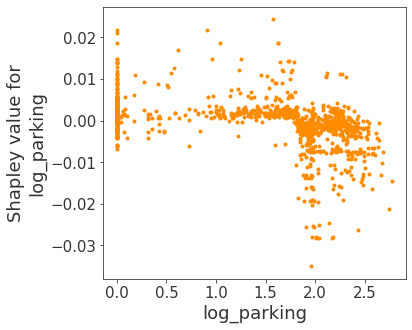

In [354]:
shap.dependence_plot("log_parking", shap_values[0], X, interaction_index=None, show=False, ax=None, color="darkorange")
plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)

plt.xlabel('log_parking',fontsize=18)
plt.ylabel('Shapley value for\nlog_parking',fontsize=18)
plt.show()

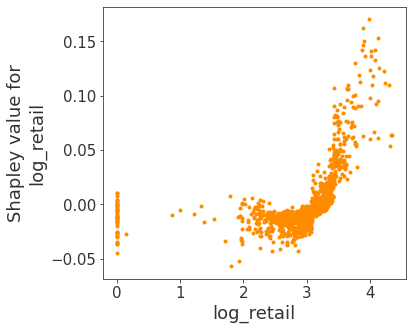

In [356]:
shap.dependence_plot("log_retail", shap_values[0], X, interaction_index=None, show=False, ax=None, color="darkorange")
plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)

plt.xlabel('log_retail',fontsize=18)
plt.ylabel('Shapley value for\nlog_retail',fontsize=18)
plt.show()

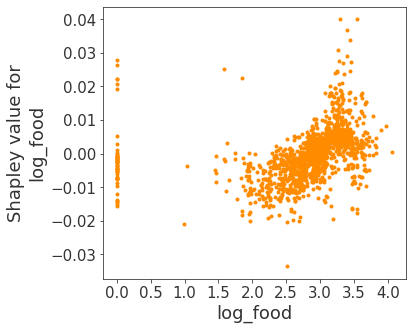

In [357]:
shap.dependence_plot("log_food", shap_values[0], X, interaction_index=None, show=False, ax=None, color="darkorange")
plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)

plt.xlabel('log_food',fontsize=18)
plt.ylabel('Shapley value for\nlog_food',fontsize=18)
plt.show()

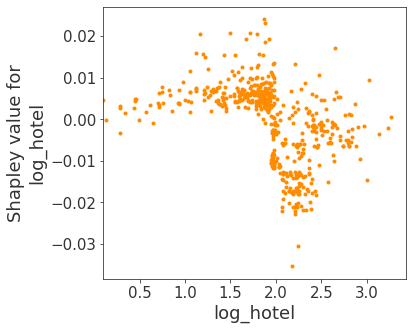

In [349]:
shap.dependence_plot("log_hotel", shap_values[0], X, interaction_index=None, xmin = 0.1, show=False, ax=None, color="darkorange")
plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)

plt.xlabel('log_hotel',fontsize=18)
plt.ylabel('Shapley value for\nlog_hotel',fontsize=18)
plt.show()

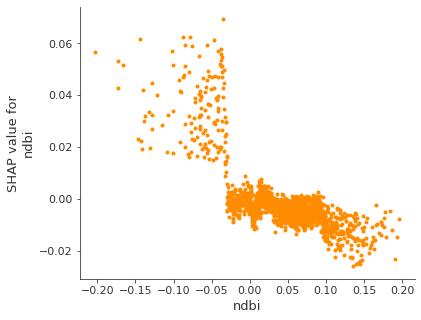

In [34]:
shap.dependence_plot("ndbi", shap_values[0], X, interaction_index=None, show=False, ax=None, color="darkorange")

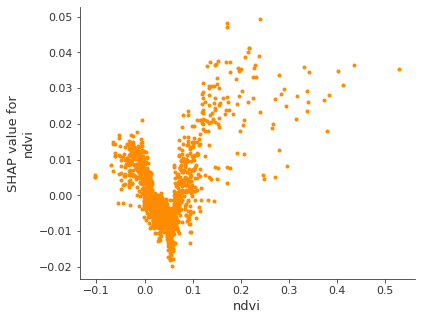

In [35]:
shap.dependence_plot("ndvi", shap_values[0], X, interaction_index=None, show=False, ax=None,color="darkorange")

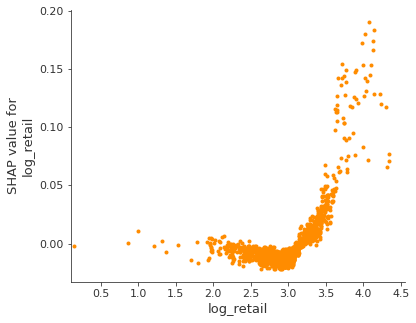

In [42]:
shap.dependence_plot("log_retail", shap_values[0], X, interaction_index=None,xmin = 0.1, show=False, ax=None,color="darkorange")

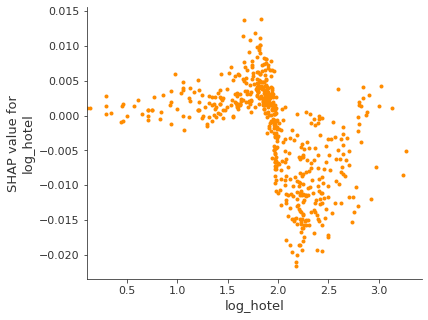

In [41]:
shap.dependence_plot("log_hotel", shap_values[0], X, interaction_index=None, show=False, xmin = 0.1, ax=None, color="darkorange")

In [70]:
pip install scipy numpy seaborn pandas statsmodels pingouin

Note: you may need to restart the kernel to use updated packages.


In [72]:
import pandas as pd

data = r"C:\Users\jhcwgtang\Downloads\ALL_Dataset.csv"
df = pd.read_csv(data)
df.head()

,bld_eui2_label,log_area,log_hotel,log_parking,log_food,log_office,log_retail,td_cdd,wind10m,ghi,...,commercial,individual_ac,central_ac,Operate_start_before8,Operate_start_8_9,Operate_start_9_10,Operate_start_after10,ndbi,ndvi,BH
0,low,2.060698,1.890600,1.748245,2.750192,0.000000,2.704174,2.50708,3.10741,1408.770020,...,0,0,0,0,0,0,0,0.145720,0.003396,37.538166
1,low,2.519828,0.000000,2.425565,2.249458,0.000000,3.067402,2.72197,2.29804,1430.319946,...,0,0,0,0,0,0,0,0.052908,0.038056,39.309444
2,low,2.660865,0.000000,1.952572,1.744457,0.000000,2.345632,2.50708,2.09989,1374.069946,...,0,0,0,0,0,0,0,-0.007362,0.052051,161.831970
3,low,2.320146,0.000000,1.568914,2.851846,2.516849,3.165167,2.68616,2.43564,1411.329956,...,0,0,0,0,0,0,0,0.066142,0.000613,75.504829
4,low,2.230449,1.954109,0.000000,2.555555,0.000000,2.773442,2.90105,2.50368,1451.140015,...,0,0,0,0,0,0,0,0.063666,0.103458,30.511705


In [73]:
low = df.query('bld_eui2_label == "low"')
high = df.query('bld_eui2_label == "high"')

In [74]:
df.groupby('bld_eui2_label').describe()

log_area                                                    \
                  count      mean       std       min       25%       50%   
bld_eui2_label                                                              
high              748.0  2.787750  0.580627  1.361728  2.390493  2.653695   
low               747.0  2.359455  0.386903  1.681241  2.110590  2.285557   

                                   log_hotel            ...      ndvi  \
                     75%       max     count      mean  ...       75%   
bld_eui2_label                                          ...             
high            3.116270  4.837228     748.0  0.634330  ...  0.068301   
low             2.519171  4.248537     747.0  0.755149  ...  0.058343   

                             BH                                              \
                     max  count       mean        std        min        25%   
bld_eui2_label                                                                
high            0.529040  748.0  69.298261  44.567139   7.769163  38.879906   
low             0.433783  747.0  54.954549  26.625771  11.060029  36.437576   

                                                  
                      50%        75%         max  
bld_eui2_label                                    
high            61.054831  88.984837  424.229645  
low             51.077156  70.294796  168.233063  

[2 rows x 176 columns]

Text(0, 0.5, 'Area in log 10 base')

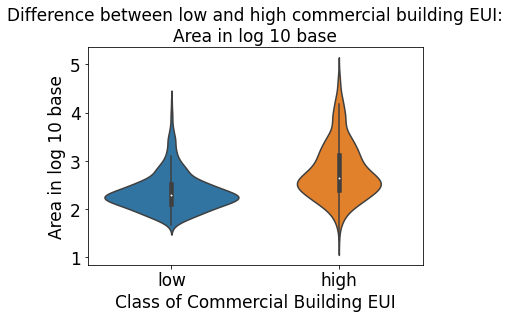

In [76]:
import seaborn as sns
plt.title('Difference between low and high commercial building EUI:\nArea in log 10 base', fontsize=17)
sns.violinplot(x='bld_eui2_label', y='log_area', order=["low","high"], data=df,dpi=300)
plt.xlabel('Class of Commercial Building EUI', fontsize=17)
plt.ylabel('Area in log 10 base', fontsize=17)

([<matplotlib.axis.YTick at 0x27beee517f0>,
 [Text(0, 0, ''), Text(0, 0, '')])

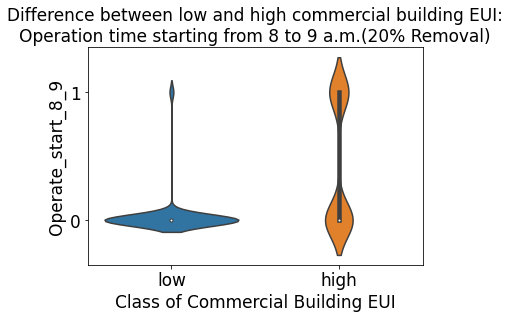

In [1543]:
plt.xlabel('Class of Commercial Building EUI', fontsize=16)
plt.title('Difference between low and high commercial building EUI:\nOperation time starting from 8 to 9 a.m.(20% Removal)', fontsize=17)
sns.violinplot(x='bld_eui2_label', y='Operate_start_8_9',  order=["low","high"], data=df)
plt.xlabel('Class of Commercial Building EUI', fontsize=17)
y_labels = [0,1]
plt.yticks(y_labels)

(0.0001, 4.017537467448794)

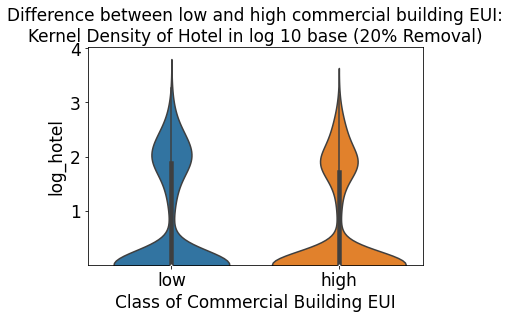

In [79]:
plt.title('Difference between low and high commercial building EUI:\nKernel Density of Hotel in log 10 base', fontsize=17)
sns.violinplot(x='bld_eui2_label', y='log_hotel', order=["low","high"], data=df)
plt.xlabel('Class of Commercial Building EUI', fontsize=17)
plt.ylim((0.0001))

(0.01, 3.4868619198841606)

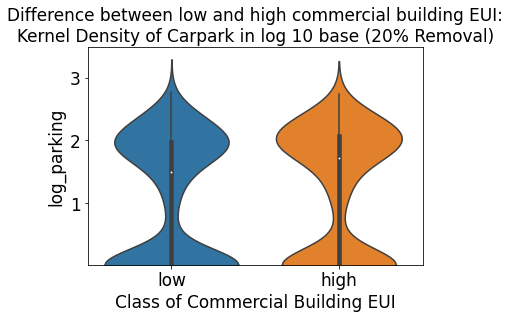

In [80]:
plt.title('Difference between low and high commercial building EUI:\nKernel Density of Carpark in log 10 base (20% Removal)', fontsize=17)
sns.violinplot(x='bld_eui2_label', y='log_parking', order=["low","high"], data=df)
plt.xlabel('Class of Commercial Building EUI', fontsize=17)
plt.ylim((0.01))

(0.0001, 4.669724590075192)

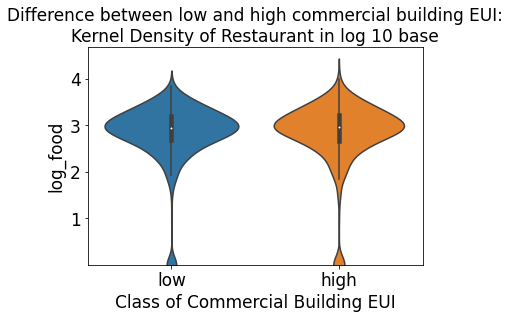

In [81]:
plt.title('Difference between low and high commercial building EUI:\nKernel Density of Restaurant in log 10 base', fontsize=17)
sns.violinplot(x='bld_eui2_label', y='log_food', order=["low","high"], data=df)
plt.xlabel('Class of Commercial Building EUI', fontsize=17)
plt.ylim((0.0001))

(0.0001, 4.799489387420641)

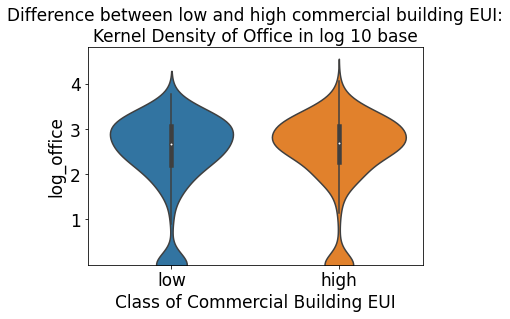

In [82]:
plt.title('Difference between low and high commercial building EUI:\nKernel Density of Office in log 10 base', fontsize=17)
sns.violinplot(x='bld_eui2_label', y='log_office', order=["low","high"], data=df)
plt.xlabel('Class of Commercial Building EUI', fontsize=17)
plt.ylim((0.0001))

(0.0001, 5.002856959186355)

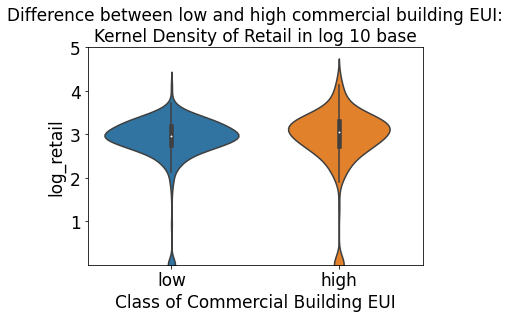

In [83]:
plt.title('Difference between low and high commercial building EUI:\nKernel Density of Retail in log 10 base', fontsize=17)
sns.violinplot(x='bld_eui2_label', y='log_retail', order=["low","high"], data=df)
plt.xlabel('Class of Commercial Building EUI', fontsize=17)
plt.ylim((0.0001))

([<matplotlib.axis.YTick at 0x272b9c40b50>,
 [Text(0, 0, ''), Text(0, 0, '')])

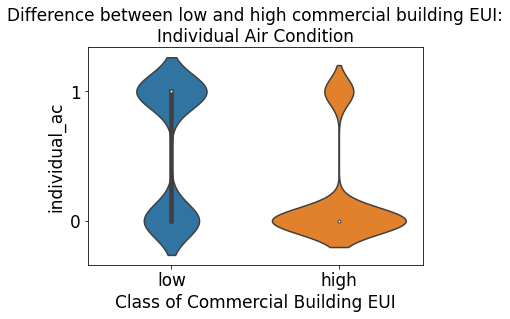

In [84]:
plt.title('Difference between low and high commercial building EUI:\nIndividual Air Condition', fontsize=17)
sns.violinplot(x='bld_eui2_label', y='individual_ac', order=["low","high"], data=df)
plt.xlabel('Class of Commercial Building EUI', fontsize=17)
y_labels = [0,1]
plt.yticks(y_labels)

([<matplotlib.axis.YTick at 0x272b9ca0340>,
 [Text(0, 0, ''), Text(0, 0, '')])

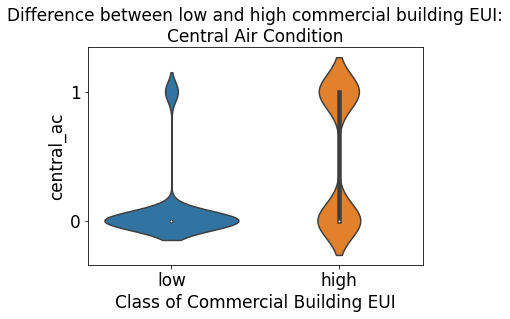

In [85]:
plt.title('Difference between low and high commercial building EUI:\nCentral Air Condition', fontsize=17)
sns.violinplot(x='bld_eui2_label', y='central_ac', order=["low","high"], data=df)
plt.xlabel('Class of Commercial Building EUI', fontsize=17)
y_labels = [0,1]
plt.yticks(y_labels)

Text(0.5, 0, 'Class of Commercial Building EUI')

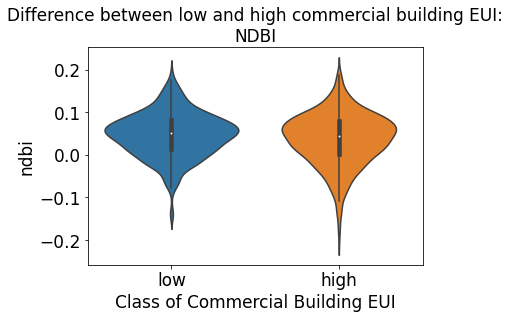

In [86]:
plt.title('Difference between low and high commercial building EUI:\nNDBI', fontsize=17)
sns.violinplot(x='bld_eui2_label', y='ndbi', order=["low","high"], data=df)
plt.xlabel('Class of Commercial Building EUI', fontsize=17)

Text(0.5, 0, 'Class of Commercial Building EUI')

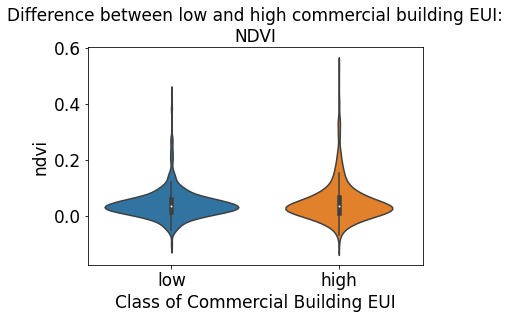

In [87]:
plt.title('Difference between low and high commercial building EUI:\nNDVI', fontsize=17)
sns.violinplot(x='bld_eui2_label', y='ndvi', order=["low","high"], data=df)
plt.xlabel('Class of Commercial Building EUI', fontsize=17)

Text(0.5, 0, 'Class of Commercial Building EUI')

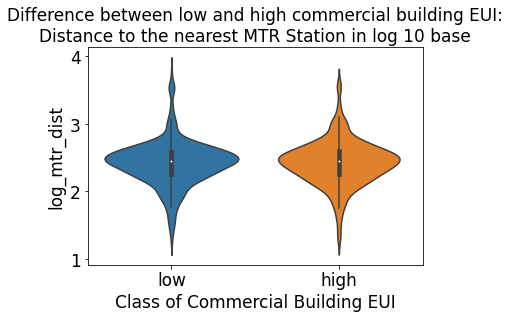

In [88]:
plt.title('Difference between low and high commercial building EUI:\nDistance to the nearest MTR Station in log 10 base', fontsize=17)
sns.violinplot(x='bld_eui2_label', y='log_mtr_dist', order=["low","high"], data=df)
plt.xlabel('Class of Commercial Building EUI', fontsize=17)

Text(0.5, 0, 'Class of Commercial Building EUI')

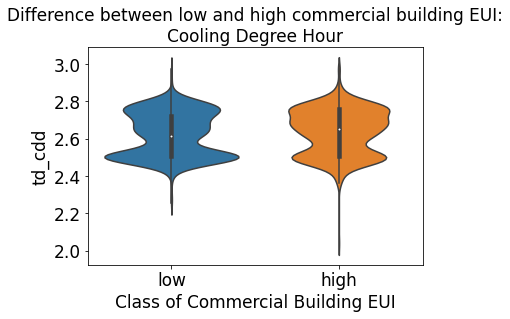

In [89]:
plt.title('Difference between low and high commercial building EUI:\nCooling Degree Hour', fontsize=17)
sns.violinplot(x='bld_eui2_label', y='td_cdd', order=["low","high"], data=df)
plt.xlabel('Class of Commercial Building EUI', fontsize=17)

Text(0.5, 0, 'Class of Commercial Building EUI')

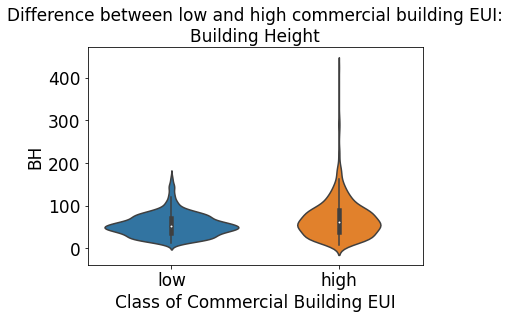

In [92]:
plt.title('Difference between low and high commercial building EUI:\nBuilding Height', fontsize=17)
sns.violinplot(x='bld_eui2_label', y='BH', order=["low","high"], data=df)
plt.xlabel('Class of Commercial Building EUI', fontsize=17)

([<matplotlib.axis.YTick at 0x27befbcb1c0>,
 [Text(0, 0, ''), Text(0, 0, '')])

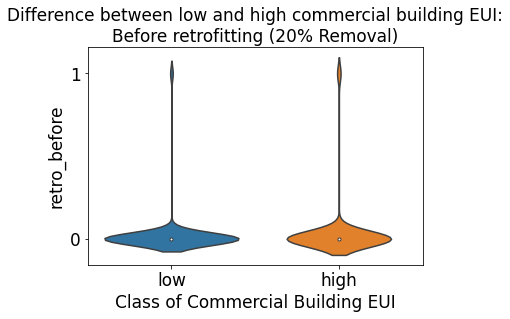

In [1557]:
plt.title('Difference between low and high commercial building EUI:\nBefore retrofitting', fontsize=17)
sns.violinplot(x='bld_eui2_label', y='retro_before', order=["low","high"], data=df)
plt.xlabel('Class of Commercial Building EUI', fontsize=17)
y_labels = [0,1]
plt.yticks(y_labels)

([<matplotlib.axis.YTick at 0x272b9a40a30>,
 [Text(0, 0, ''), Text(0, 0, '')])

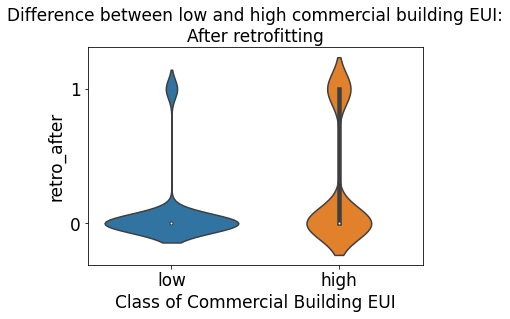

In [93]:
plt.title('Difference between low and high commercial building EUI:\nAfter retrofitting', fontsize=17)
sns.violinplot(x='bld_eui2_label', y='retro_after', order=["low","high"], data=df)
plt.xlabel('Class of Commercial Building EUI', fontsize=17)
y_labels = [0,1]
plt.yticks(y_labels)

([<matplotlib.axis.YTick at 0x272b9abe2e0>,
 [Text(0, 0, ''), Text(0, 0, '')])

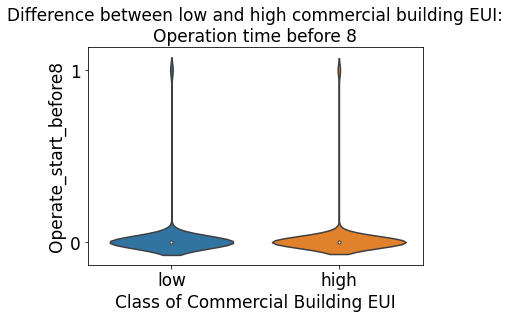

In [95]:
plt.title('Difference between low and high commercial building EUI:\nOperation time before 8', fontsize=17)
sns.violinplot(x='bld_eui2_label', y='Operate_start_before8', order=["low","high"], data=df)
plt.xlabel('Class of Commercial Building EUI', fontsize=17)
y_labels = [0,1]
plt.yticks(y_labels)

Text(0.5, 0, 'Class of Commercial Building EUI')

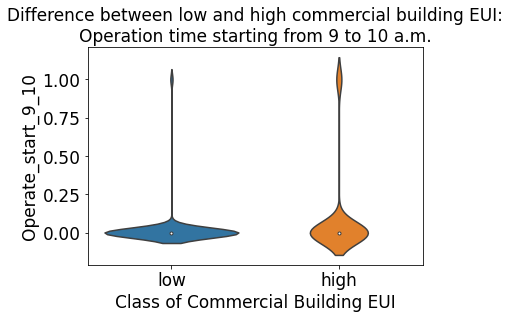

In [96]:
plt.title('Difference between low and high commercial building EUI:\nOperation time starting from 9 to 10 a.m.', fontsize=17)
sns.violinplot(x='bld_eui2_label', y='Operate_start_9_10', order=["low","high"], data=df)
plt.xlabel('Class of Commercial Building EUI', fontsize=17)

([<matplotlib.axis.YTick at 0x272b9f2e8e0>,
 [Text(0, 0, ''), Text(0, 0, '')])

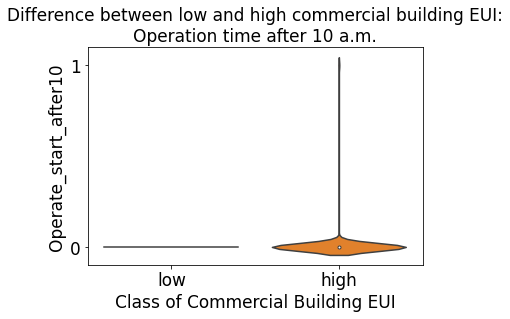

In [97]:
plt.title('Difference between low and high commercial building EUI:\nOperation time after 10 a.m.', fontsize=17)
sns.violinplot(x='bld_eui2_label', y='Operate_start_after10', order=["low","high"], data=df)
plt.xlabel('Class of Commercial Building EUI', fontsize=17)
y_labels = [0,1]
plt.yticks(y_labels)

Text(0.5, 0, 'Class of Commercial Building EUI')

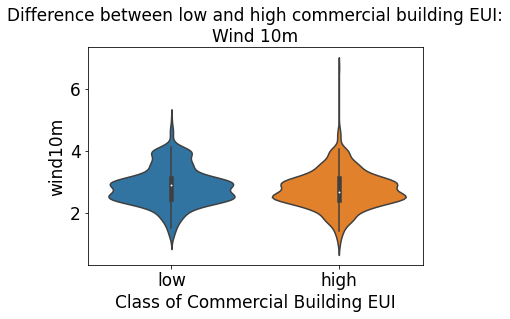

In [98]:
plt.title('Difference between low and high commercial building EUI:\nWind 10m', fontsize=17)
sns.violinplot(x='bld_eui2_label', y='wind10m', order=["low","high"], data=df)
plt.xlabel('Class of Commercial Building EUI', fontsize=17)

([<matplotlib.axis.YTick at 0x27bf0f18970>,
 [Text(0, 0, ''), Text(0, 0, '')])

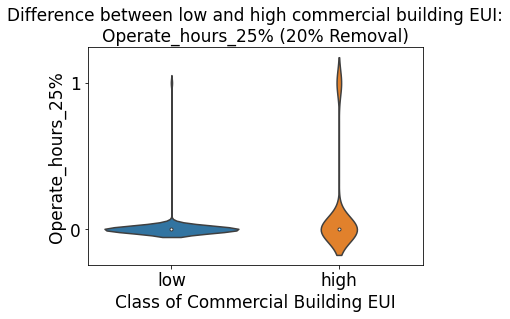

In [1564]:
plt.title('Difference between low and high commercial building EUI:\nOperate_hours_25%', fontsize=17)
sns.violinplot(x='bld_eui2_label', y='Operate_hours_25%', order=["low","high"], data=df)
plt.xlabel('Class of Commercial Building EUI', fontsize=17)
y_labels = [0,1]
plt.yticks(y_labels)

ValueError: Could not interpret input 'Operate_hours_50%'

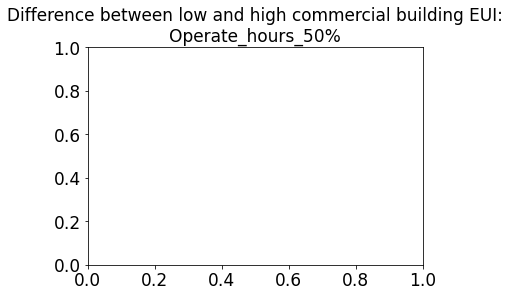

In [100]:
plt.title('Difference between low and high commercial building EUI:\nOperate_hours_50%', fontsize=17)
sns.violinplot(x='bld_eui2_label', y='Operate_hours_50%', order=["low","high"], data=df)
plt.xlabel('Class of Commercial Building EUI', fontsize=17)
y_labels = [0,1]
plt.yticks(y_labels)

([<matplotlib.axis.YTick at 0x27bf0fc8fa0>,
 [Text(0, 0, ''), Text(0, 0, '')])

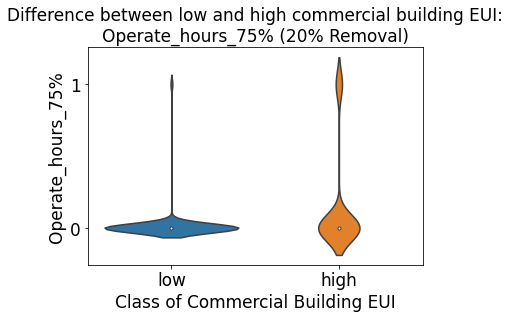

In [1566]:
plt.title('Difference between low and high commercial building EUI:\nOperate_hours_75%', fontsize=17)
sns.violinplot(x='bld_eui2_label', y='Operate_hours_75%', order=["low","high"], data=df)
plt.xlabel('Class of Commercial Building EUI', fontsize=17)
y_labels = [0,1]
plt.yticks(y_labels)

([<matplotlib.axis.YTick at 0x27bf1176310>,
 [Text(0, 0, ''), Text(0, 0, '')])

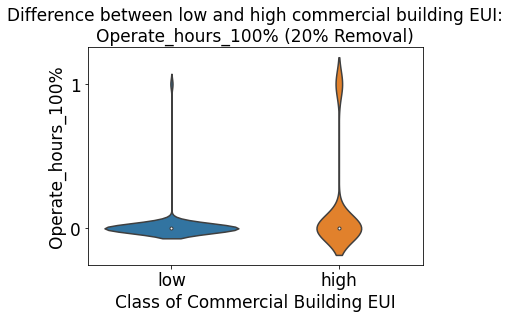

In [1567]:
plt.title('Difference between low and high commercial building EUI:\nOperate_hours_100%', fontsize=17)
sns.violinplot(x='bld_eui2_label', y='Operate_hours_100%', order=["low","high"], data=df)
plt.xlabel('Class of Commercial Building EUI', fontsize=17)
y_labels = [0,1]
plt.yticks(y_labels)

([<matplotlib.axis.YTick at 0x27bf11ce640>,
 [Text(0, 0, ''), Text(0, 0, '')])

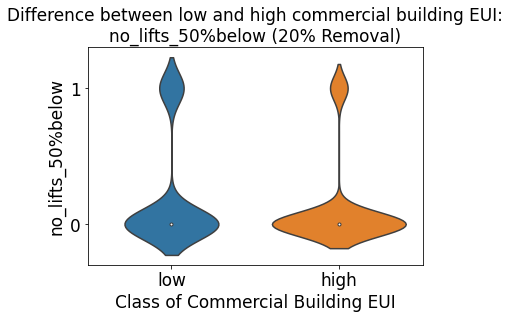

In [1568]:
plt.title('Difference between low and high commercial building EUI:\nno_lifts_50%below', fontsize=17)
sns.violinplot(x='bld_eui2_label', y='no_lifts_50%below', order=["low","high"], data=df)
plt.xlabel('Class of Commercial Building EUI', fontsize=17)
y_labels = [0,1]
plt.yticks(y_labels)

([<matplotlib.axis.YTick at 0x27bf1226970>,
 [Text(0, 0, ''), Text(0, 0, '')])

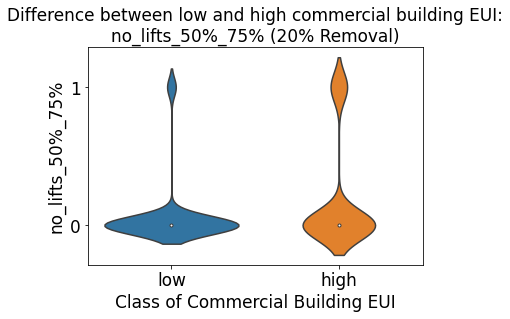

In [1569]:
plt.title('Difference between low and high commercial building EUI:\nno_lifts_50%_75%', fontsize=17)
sns.violinplot(x='bld_eui2_label', y='no_lifts_50%_75%', order=["low","high"], data=df)
plt.xlabel('Class of Commercial Building EUI', fontsize=17)
y_labels = [0,1]
plt.yticks(y_labels)

([<matplotlib.axis.YTick at 0x27bf127eca0>,
 [Text(0, 0, ''), Text(0, 0, '')])

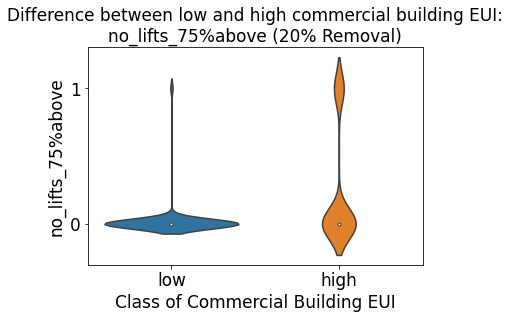

In [1570]:
plt.title('Difference between low and high commercial building EUI:\nno_lifts_75%above', fontsize=17)
sns.violinplot(x='bld_eui2_label', y='no_lifts_75%above', order=["low","high"], data=df)
plt.xlabel('Class of Commercial Building EUI', fontsize=17)
y_labels = [0,1]
plt.yticks(y_labels)

([<matplotlib.axis.YTick at 0x27bf1466fd0>,
 [Text(0, 0, ''), Text(0, 0, '')])

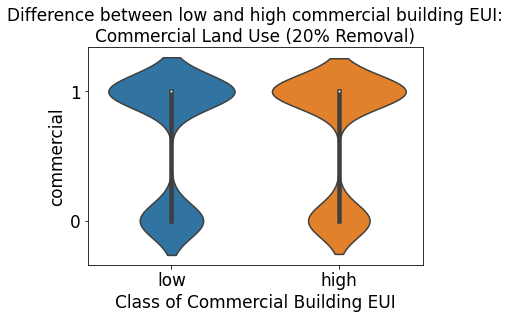

In [1571]:
plt.title('Difference between low and high commercial building EUI:\nCommercial Land Use', fontsize=17)
sns.violinplot(x='bld_eui2_label', y='commercial', order=["low","high"], data=df)
plt.xlabel('Class of Commercial Building EUI', fontsize=17)
y_labels = [0,1]
plt.yticks(y_labels)

In [ ]:
from scipy import stats
from statsmodels.stats.weightstats import ttest_ind

ttest_ind(low, high)